This script plots 2-D plots of a given variable corresponding to a given year relative to another variable. 
For example, if specified, plot the average June, July, August, and September 500 mb geopotential heights for 
the year in which the most precipitation fell in those same months over the Colorado Plateau.  The user can 
specify if they want to plot multiple years.  All months in that year will be plotted in 1 figure.  The user can 
also choose if they want to plot the averaged years or months, or plot them individually.  

In [1]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar
import importlib

# math and data
import math
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import scipy.linalg
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
misc_data_path = '/glade/u/home/zcleveland/scratch/misc_data/'  # path to misc data
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated plots
scripts_main_path = '/glade/u/home/zcleveland/NAM_soil-moisture/scripts_main/'  # path to my dicts, lists, and functions

# import variable lists and dictionaries
if scripts_main_path not in sys.path:
    sys.path.insert(0, scripts_main_path)  # path to file containing these lists/dicts
if 'get_var_data' in sys.modules:
    importlib.reload(sys.modules['get_var_data'])
if 'my_functions' in sys.modules:
    importlib.reload(sys.modules['my_functions'])
if 'my_dictionaries' in sys.modules:
    importlib.reload(sys.modules['my_dictionaries'])

# import common functions that I've created
from get_var_data import get_var_data, get_var_files, open_var_data, subset_var_data, time_to_year_month_avg, time_to_year_month_sum, time_to_year_month
from my_functions import month_num_to_name, ensure_var_list

# import lists and dictionaries
import my_dictionaries
# my lists
sfc_instan_list = my_dictionaries.sfc_instan_list  # instantaneous surface variables
sfc_accumu_list = my_dictionaries.sfc_accumu_list  # accumulated surface variables
pl_var_list = my_dictionaries.pl_var_list  # pressure level variables
invar_var_list = my_dictionaries.invar_var_list  # invariant variables
NAM_var_list = my_dictionaries.NAM_var_list  # NAM-based variables
region_avg_list = my_dictionaries.region_avg_list  # region IDs for regional averages
flux_var_list = my_dictionaries.flux_var_list  # flux variables that need to be flipped (e.g., sensible heat so that it's positive up instead of down
misc_var_list = my_dictionaries.misc_var_list  # misc variables
# my dictionaries
var_dict = my_dictionaries.var_dict  # variables and their names
var_units = my_dictionaries.var_units  # variable units
region_avg_dict = my_dictionaries.region_avg_dict  # region IDs and names
region_avg_coords = my_dictionaries.region_avg_coords  # coordinates for regions
region_colors_dict = my_dictionaries.region_colors_dict  # colors to plot for each region

In [2]:
def main(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years=[1, 2, 3, 4, 5], **kwargs):
    """
    Synchronizes the data in var1 and var2 by sorting the yearly data (summed or averaged over specified months)
    in descending order. e.g., most -> least precipitation in MJJASO at some lat/lon combo = (1981, 1990, ...2004).
    SFC accumulated variables are summed and all others are averaged.

    Parameters
    ----------
    var1 : str
        The variable used to do the sorting of years.
    var1_months : list, int
        The months to consider in summing or averaging var1.
    var1_region : str
        The region over which to average latitude/longitude points of var1.
    var2 : str
        The variable to plot relative to the sorted order of var1.
    var2_months : list, int
        The months to consider in summing or averaging var2.
    var2_region : str
        The region over which to average latitude/longitude points of var2.
    rank_years : list, int, optional
        A list of the number of year to plot by rank order. i.e., 1 is most and 40 is least. default is 5 max years.
    """
    # get output filename and path
    fn_core, out_fn = get_out_fn(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years, **kwargs)
    out_fp = f'{plot_out_path}max_min_years/{out_fn}'
    # check if it already exists
    if os.path.exists(out_fp):
        if not kwargs.get('overwrite_flag', False):
            if kwargs.get('show_png', False):
                show_my_plot(out_fp)
            return

    # get var1 and var2 data
    var1_data = get_var_data(var1, region=var1_region, level=kwargs.get('var1_level', None), **kwargs)
    var2_data = get_var_data(var2, region=var2_region, level=kwargs.get('var2_level', None))

    # make sure var1 and var2 are in (year, month, ...).  (year, ...) for NAM variables
    var1_data = time_to_year_month(var1, var1_data)
    var2_data = time_to_year_month(var2, var2_data)

    # flip sign variables that need to be redefined for positive up
    if var1 in pl_var_list:
        var1_data = var1_data * -1

    # get sorted years info for var1
    sorted_years = order_var_years(var1, var1_data, rank_years, var1_months, **kwargs)  # years in descending order by var1 mean or sum

    # extract var2 data for specified months over all years
    var2_data_monthly = extract_var_monthly(var2, var2_data, var2_months)
    # calculate anomaly (deseasonalize data)
    var2_data_anomaly = calc_anomaly(var2_data_monthly, zscore=kwargs.get('zscore_anomaly', False))
    # calculate min, max, and mean of anomaly for shaded contour plotting
    vmin, vmax = calc_vmin_vmax(var2_data_anomaly, zscore=kwargs.get('zscore_anomaly', False))
    var2_data_anomaly_mean = calc_var_mean(var2_data_anomaly.sel(year=sorted_years))
    # calculate mean of var2_data for sorted_years and var2_months for contour plotting
    var2_data_mean = calc_yearly_mean_sum(var2, var2_data_monthly.sel(year=sorted_years))

    # get figure title and plot data
    fig_title = make_fig_title(var1, var1_region, var1_months, var1_data, var2, var2_region, var2_months, sorted_years, rank_years)
    plot_max_min_data(var2, var2_data_mean, var2_data_anomaly_mean, vmin, vmax, fig_title, out_fp, **kwargs)

In [3]:
def calc_monthly_mean_sum(var, da, months, **kwargs):
    if 'month' not in da.dims:
        return da  # only execute this code if month is actually a dimension

    da = da.sel(month=months)
    if var in sfc_accumu_list:  # sum accumulated variables
        return da.groupby('year').sum('month', skipna=True)
    else:  # average all other variables
        return da.groupby('year').mean('month', skipna=True)


def order_var_years(var, da, rank_years, months, **kwargs):
    # get monthly mean or sum of years and specified months
    da_temp = calc_monthly_mean_sum(var, da, months)
    sorted_indices = da_temp.compute().argsort().values
    if var != 'onset':
        sorted_indices = np.flip(sorted_indices)
    da_sorted = da_temp.year[sorted_indices]  # arr_years sorted in descending order
    return da_sorted[np.array(rank_years)-1].values

In [4]:
def get_out_fn(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years, **kwargs):
    var1_level = kwargs.get('var1_level', '')
    var2_level = kwargs.get('var2_level', '')

    var1_month_names = month_num_to_name(var1, var1_months)
    var2_month_names = month_num_to_name(var2, var2_months)

    # create core of output file name
    rank = '-'.join([str(rank_years[0]), str(rank_years[-1])])
    fn_list = [str(var1), str(var1_level), str(var1_month_names), str(var1_region),
               'rank', str(rank),
               str(var2), str(var2_level), str(var2_month_names), str(var2_region)]
    fn_core = '_'.join([i for i in fn_list if i != ''])

    out_fn = f'ranked_{fn_core}.png'

    return fn_core, out_fn

In [5]:
def calc_anomaly(da, zscore=False, **kwargs):
    mean, std = calc_var_mean(da, return_std=True)
    return (da - mean) / std if zscore else da - mean

In [6]:
def calc_var_mean(da, return_std=False, exclude_dims=['latitude', 'longitude'], **kwargs):
    dims = [d for d in da.dims if d not in exclude_dims]
    mean = da.mean(dims, skipna=True)
    std = da.std(dims, skipna=True) if return_std else None
    return (mean, std) if return_std else mean

In [7]:
def calc_vmin_vmax(da, zscore=False, **kwargs):
    return (-1, 1) if zscore else (da.min(skipna=True).values, da.max(skipna=True).values)

In [8]:
def calc_yearly_mean_sum(var, da, exclude_dims=['latitude', 'longitude'], **kwargs):
    dims = [d for d in da.dims if d not in exclude_dims]
    if var in sfc_accumu_list:
        return da.sum(dims, skipna=True)
    else:
        return da.mean(dims, skipna=True)

In [9]:
def extract_var_monthly(var, da, months, **kwargs):
    return da.sel(month=months) if 'month' in da.dims else da

In [10]:
def extract_var_yearly_mean_sum(var, da, years, months, **kwargs):
    da = da.sel(year=years, month=months) if 'month' in da.dims else da.sel(year=years)
    # calc monthly means dims=(year, month, ...)
    if var in sfc_accumu_list:
        return da.sum(skipna=True)
    else:
        return da.mean(skipna=True)

In [11]:
def make_fig_title(var1, var1_region, var1_months, var1_data, var2, var2_region, var2_months, sorted_years, ranks, **kwargs):
    years = ', '.join([f"'{str(y)[-2:]}" for y in sorted_years])
    var1_month_names = month_num_to_name(var1, var1_months)
    var2_month_names = month_num_to_name(var2, var2_months)
    var1_data_mean = extract_var_yearly_mean_sum(var1, var1_data, sorted_years, var1_months).values
    return f'{var_dict[var2]} ({var2_month_names})\n{years}\nRank {ranks[0]}-{ranks[-1]} for {var_dict[var1]} ({var1_month_names} {var1_region})\nmean/sum: {var1_data_mean:.4f} {var_units[var1]}'

In [12]:
def show_my_plot(out_fp):
    print('Showing existing plot . . .')
    fig = plt.figure(figsize=(12,18))
    img = mpimg.imread(out_fp)
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

In [13]:
def plot_max_min_data(var2, var2_data_mean, var2_data_anomaly_mean, vmin, vmax, fig_title, out_fp, **kwargs):
    # set up figure
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12,18), subplot_kw=dict(projection=projection))
    # set contour levels and norm
    cf_levels = np.arange(vmin, vmax+0.02, 0.02)
    norm = plt.Normalize(vmin, vmax)
    # plot data
    cf = ax.contourf(var2_data_anomaly_mean.longitude, var2_data_anomaly_mean.latitude,
                     var2_data_anomaly_mean, levels=cf_levels, norm=norm,
                     cmap=kwargs.get('cmap', 'RdBu_r'), extend='both', transform=ccrs.PlateCarree())

    cs = ax.contour(var2_data_mean.longitude, var2_data_mean.latitude,
                    var2_data_mean, levels=10, linewidths=1, linestyles='--', colors='black', transform=ccrs.PlateCarree())

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # set title and colorbars
    cb = fig.colorbar(cf, ax=ax, orientation='horizontal', label=f'{var_units[var2]}', pad=0.02)
    cb.set_ticks(np.arange(vmin, vmax+0.2, 0.2))
    plt.clabel(cs, inline=True, fontsize=8, fmt='%1.2f', inline_spacing=10)
    plt.title(fig_title, fontsize=18)
    plt.tight_layout()
    # save, show, and close plot
    if kwargs.get('save_png', False):
        plt.savefig(out_fp, bbox_inches='tight', dpi=300)
    if kwargs.get('show_png', True):
        plt.show()
    plt.close()

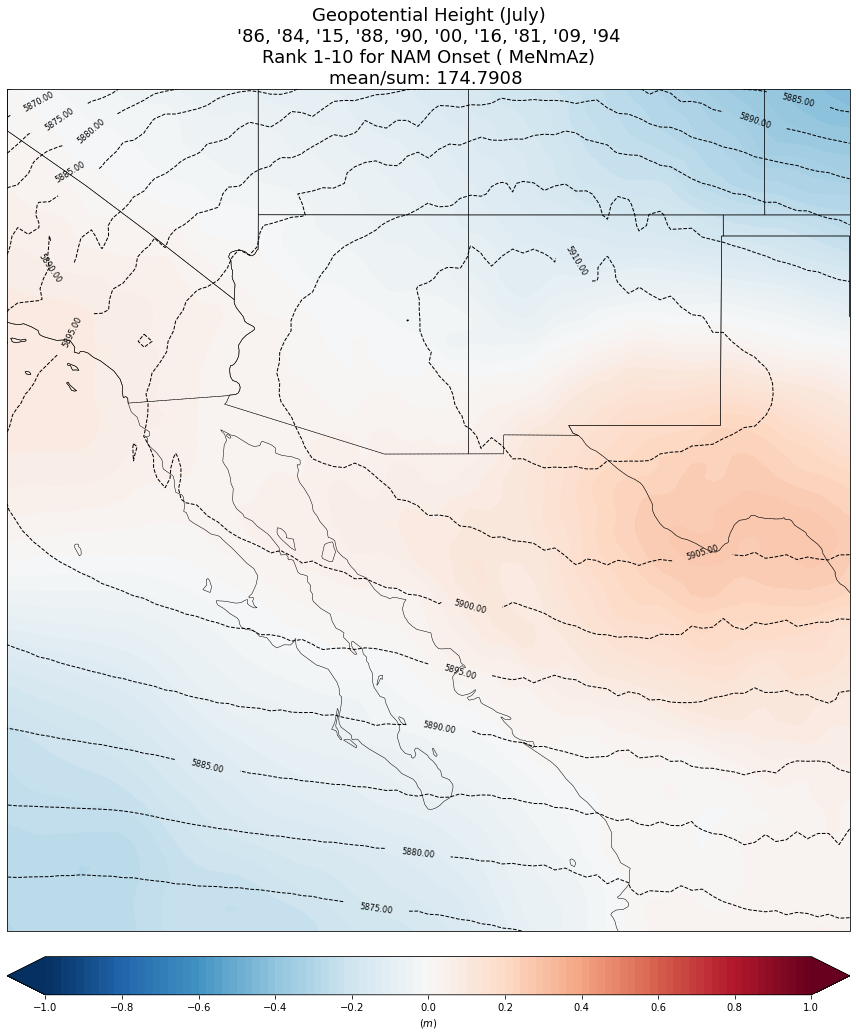

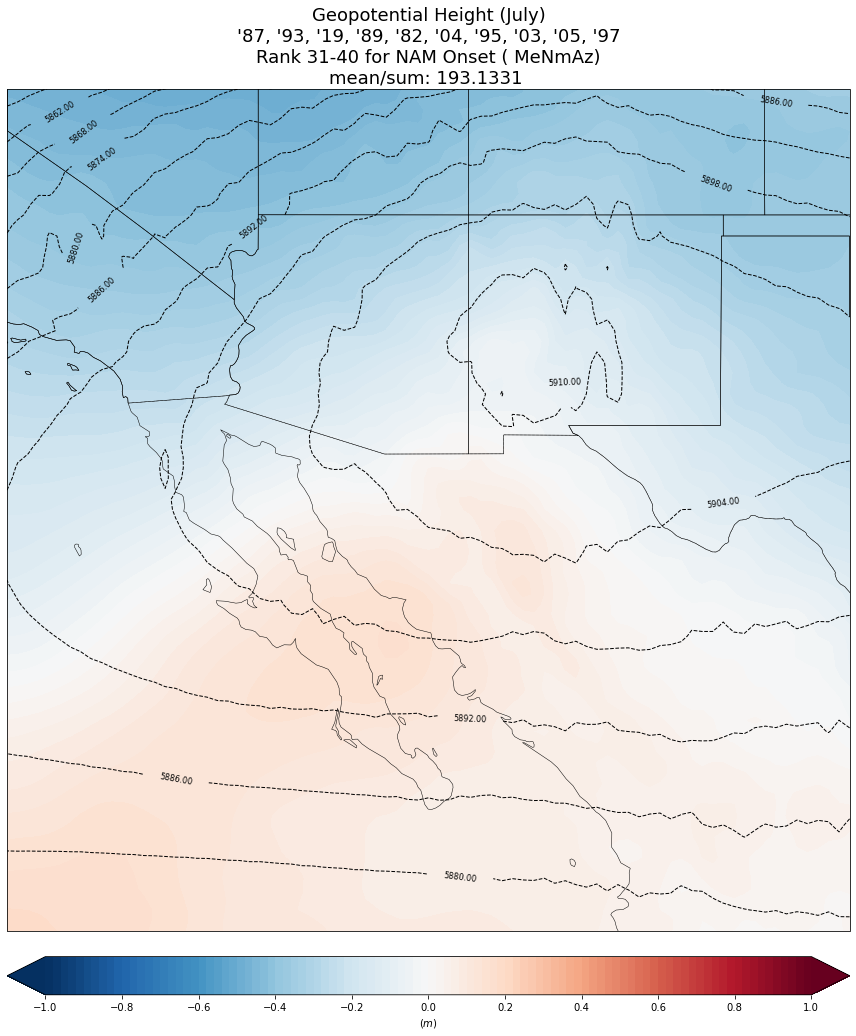

In [14]:
# cell to call main() and plot data
var1 = 'onset'
var1_months = [6, 7, 8, 9]
var1_region = 'MeNmAz'

var2 = 'z_height'
var2_months = [7]
var2_region = 'dsw'

var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}

main_kwargs = {
    'overwrite_flag': False,
    'save_png': False,
    'show_png': True,
    'zscore_anomaly': True,
}

if __name__ == '__main__':
    kwargs = main_kwargs.copy()
    if var1_region == 'dsw':
        kwargs.update({'dim_means': ['latitude', 'longitude']})
    if var1 in pl_var_list:
        kwargs.update({'var1_level': var_kwargs['var1_level']})
    if var2 in pl_var_list:
        kwargs.update({'var2_level': var_kwargs['var2_level']})

    main(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years=[i for i in range(1,11)], **kwargs)
    main(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years=[i for i in range(31,41)], **kwargs)

In [ ]:
# cell to call main() and plot data
var1_list = ['onset', 'length', 'precipitation', 'precipitation-rate', 'tp']
var1_months = [6, 7, 8, 9]
var1_region_list = ['cp', 'MeNmAz', 'chi', 'son', 'moj', 'dsw']

var2 = 'z_height'
var2_months = [6]
var2_region = 'dsw'

var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}

main_kwargs = {
    'overwrite_flag': False,
    'save_png': True,
    'show_png': False,
    'zscore_anomaly': True,
}

if __name__ == '__main__':
    cnt=1
    len_lists = len(var1_list) * len(var1_region_list)
    for var1 in var1_list:
        for var1_region in var1_region_list:
            print(f'var1: {var1}, var1_region: {var1_region}, var2_months: {var2_months}')
            print(f'loop: {cnt} of {len_lists} -- {cnt / len_lists:.2f}%')
            kwargs = main_kwargs.copy()
            if var1_region == 'dsw':
                kwargs.update({'dim_means': ['latitude', 'longitude']})
            if var1 in pl_var_list:
                kwargs.update({'var1_level': var_kwargs['var1_level']})
            if var2 in pl_var_list:
                kwargs.update({'var2_level': var_kwargs['var2_level']})
            main(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], **kwargs)
            main(var1, var1_region, var1_months, var2, var2_region, var2_months, rank_years=[31, 32, 33, 34, 35, 36, 37, 38, 39, 40], **kwargs)
            cnt=cnt+1